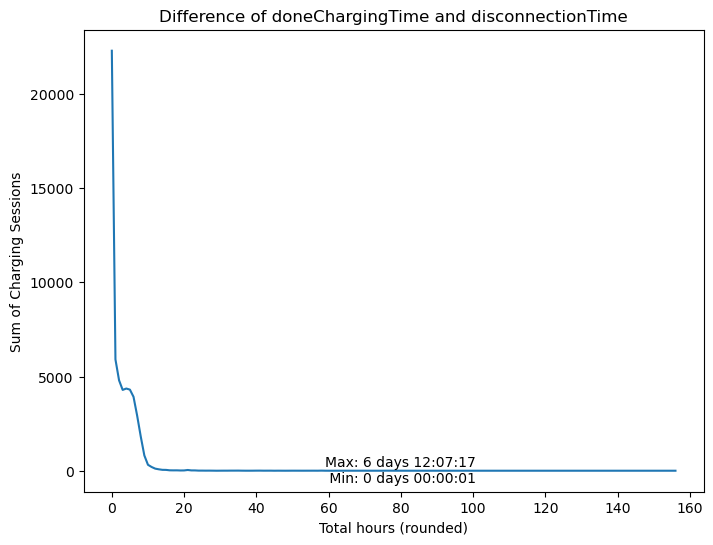

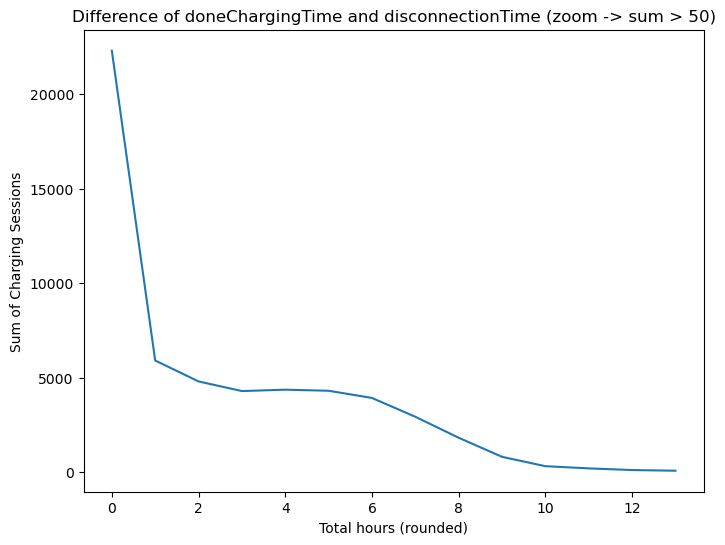

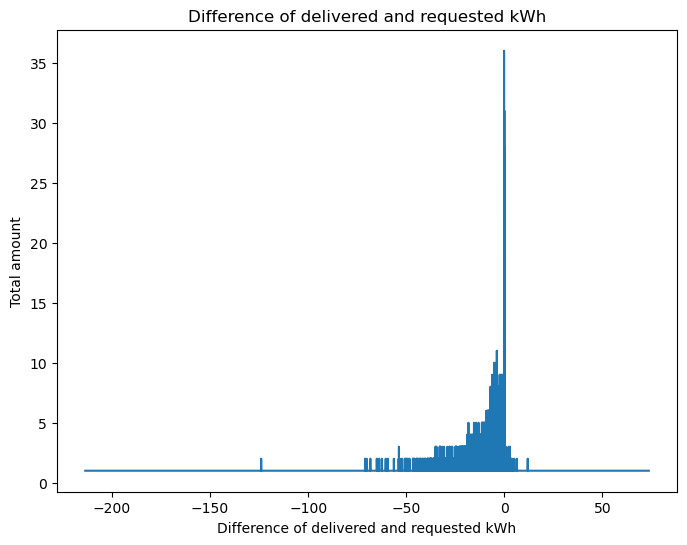

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np

csv_file_path = 'charging_sessions.csv'

df = pd.read_csv(csv_file_path, delimiter=',', quotechar='"')

# Hilfsfunktion zum Erstellen der userInput Tabelle
def parse_user_inputs(row):
    
    user_inputs = row['userInputs']
    id = row['id']

    if isinstance(user_inputs, str):
        try:
            # Konvertieren des Strings in ein Python-Dictionary
            user_inputs_data = ast.literal_eval(user_inputs)

            for entry in user_inputs_data:
                entry['id'] = id
            
            return user_inputs_data
        except Exception as e:
            print(f"Fehler beim Parsen von userInputs für ID {id}: {e}")
            return []
    else:
        return []
    

# Konvertieren der Datentypen in charging_sessions
df['id'] = df['id'].astype(str)
df['connectionTime'] = pd.to_datetime(df['connectionTime'], utc=True)
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], utc=True)
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'], utc=True)
df['kWhDelivered'] = df['kWhDelivered'].astype(float)
df['sessionID'] = df['sessionID'].astype(str)
df['siteID'] = df['siteID'].astype(str)
df['spaceID'] = df['spaceID'].astype(str)
df['stationID'] = df['stationID'].astype(str)
df['timezone'] = df['timezone'].astype(str)
df['userID'] = df['userID'].astype(str)
    

# Löscht Spalte Unnamed und anschließend alle Duplikate    
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.drop(df.columns[df.columns.str.contains('timezone',case = False)],axis = 1, inplace = True)
df = df.drop_duplicates()


# Erstelle DataFrame user_inputs_df
user_inputs_list = df.apply(parse_user_inputs, axis=1)
user_inputs_df = pd.DataFrame([item for sublist in user_inputs_list for item in sublist])


# löscht userInputs, da in eigener Tabelle
df = df.drop('userInputs', axis=1)


# Konvertieren der Datentypen in user_inputs_df
user_inputs_df['WhPerMile'] = user_inputs_df['WhPerMile'].astype(float)
user_inputs_df['kWhRequested'] = user_inputs_df['kWhRequested'].astype(float)
user_inputs_df['milesRequested'] = user_inputs_df['milesRequested'].astype(float)
user_inputs_df['minutesAvailable'] = user_inputs_df['minutesAvailable'].astype(float)
user_inputs_df['modifiedAt'] = pd.to_datetime(user_inputs_df['modifiedAt'], utc=True)
user_inputs_df['paymentRequired'] = user_inputs_df['paymentRequired'].astype(bool)
user_inputs_df['requestedDeparture'] = pd.to_datetime(user_inputs_df['requestedDeparture'], utc=True)


# Duplikate in user_inputs_df löschen
duplikate_id_user = user_inputs_df[user_inputs_df.duplicated()]
user_inputs_df = user_inputs_df.drop_duplicates()


#### KPIs ####


# KPI - Difference of doneChargingTime and DisconnectionTime in hours
# Car is connected but is fully charged

# Calculcate difference of disconnect and doneCharging times
conDiff = df['disconnectTime'] - df['doneChargingTime']
# Filter negative values
conDiffPos = conDiff[conDiff.values > pd.Timedelta(0)].sort_values(ascending=True)

max = conDiffPos.max()
min = conDiffPos.min()
# Group by hour and count values
diffCounts = conDiffPos.apply(lambda x : (x/np.timedelta64(1, 'h'))).astype(int).value_counts().sort_index()
diffCountsZoom = diffCounts[diffCounts.values > 50]

## Plot
plt.figure(figsize=(8, 6))

plt.plot(diffCounts.index, diffCounts.values)

plt.xlabel('Total hours (rounded)')
plt.ylabel('Sum of Charging Sessions')
plt.title('Difference of doneChargingTime and disconnectionTime')
plt.text(80, 0, f'Max: {max}\n Min: {min}', horizontalalignment='center', verticalalignment='center')
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(diffCountsZoom.index, diffCountsZoom.values)

plt.xlabel('Total hours (rounded)')
plt.ylabel('Sum of Charging Sessions')
plt.title('Difference of doneChargingTime and disconnectionTime (zoom -> sum > 50)')
plt.show()

# KPI - recurring users

dfUsers = df.loc[:, ('userID', 'connectionTime')] 
dfUsers['connectionTime'] = dfUsers['connectionTime'].dt.date
# recurringUsers = dfUsers[dfUsers.groupby('userID').userID.transform(len) > 1]
recurringUsers = dfUsers['userID'].value_counts().sort_values()


# KPI - Difference of kWhRequested and kWhDelivered

# Find rows with latest modified time per ID
idx_max_values = user_inputs_df.groupby('id')['modifiedAt'].idxmax()
# Filter dataframe with latest modified times per ID
filtered_user_df = user_inputs_df.loc[idx_max_values]
# Merge dataframe and filtered user dataframe
merged_table = pd.merge(df.drop('userID', axis=1), filtered_user_df, on='id', how='inner')
# Calculate difference of delivered and requested kWh per session
merged_table['kwhDiff'] = merged_table['kWhDelivered'] - merged_table['kWhRequested']

kwhDiffCounts = merged_table['kwhDiff'].value_counts().sort_index()

## Plot
plt.figure(figsize=(8, 6))

plt.plot(kwhDiffCounts.index, kwhDiffCounts.values)

plt.xlabel('Difference of delivered and requested kWh')
plt.ylabel('Total amount')
plt.title('Difference of delivered and requested kWh')
plt.show()